## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yichen Wang, Yihang Chen**

In [180]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for the each year's data). We did not re-run them here.

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5, UNF:6:cIUB3CEIKhMi9tiY4BffLg== [fileUNF]

In [181]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld


In [182]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(10) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
1486,1998,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,NaN,NaN,True,total,665,221807,False,20210114,OTHER
2032,2004,LOUISIANA,LA,22,72,45,US SENATE,statewide,gen,False,JOHN KENNEDY,DEMOCRAT,False,total,275821,1848056,False,20210114,DEMOCRAT
796,1988,INDIANA,IN,18,32,22,US SENATE,statewide,gen,False,JACK WICKES,DEMOCRAT,False,total,668778,2099303,False,20210114,DEMOCRAT
3610,2020,TEXAS,TX,48,74,49,US SENATE,statewide,gen,False,"MARY ""MJ"" HEGAR",DEMOCRAT,False,total,4888764,11144040,False,20210114,DEMOCRAT
3221,2016,OHIO,OH,39,31,24,US SENATE,statewide,gen,False,TED STRICKLAND,DEMOCRAT,False,total,1996908,5374164,False,20210114,DEMOCRAT
2692,2012,FLORIDA,FL,12,59,43,US SENATE,statewide,gen,False,BILL NELSON,DEMOCRAT,False,total,4523451,8189946,False,20210114,DEMOCRAT
756,1986,UTAH,UT,49,87,67,US SENATE,statewide,gen,False,MARY ZINS,SOCIALIST WORKERS,False,total,1863,435111,False,20210114,OTHER
2825,2012,TEXAS,TX,48,74,49,US SENATE,statewide,gen,False,PAUL SADLER,DEMOCRAT,False,total,3194927,7864822,False,20210114,DEMOCRAT
1045,1992,GEORGIA,GA,13,58,44,US SENATE,statewide,gen,False,"WYCHE FOWLER, JR.",DEMOCRAT,False,total,618877,1253991,False,20210114,DEMOCRAT
2152,2006,HAWAII,HI,15,95,82,US SENATE,statewide,gen,False,LLOYD JEFFREY MALLAN,LIBERTARIAN,False,total,6415,342842,False,20210114,LIBERTARIAN


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [183]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
senate_candidates = senate_election[senate_election['year'] >= 2016]['candidate'].dropna().unique()

**We donot run the cell below because takes too long**

In [ ]:
# Load each year's data, filtering out the quotations said by senates
# For now, we ignore name variations of the same persion, just focusing the names
# provided in the senate candidates dataset
import bz2
import json

path_to_file = 'RawData/quotes-2015.json.bz2' 
path_to_out = 'SenateData/quotes-2015-senates.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            if instance['speaker'].upper() in senate_candidates: # only load the quotes said by wanted 
              urls = instance['urls'] # extracting list of links
              domains = []
              for url in urls:
                  tld = get_domain(url)
                  domains.append(tld)
              instance['domains'] = domains # updating the sample with domain name
              d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [184]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate']).drop_duplicates(subset=['candidate'], ignore_index=True)


In [185]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')


In [186]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames)
candidate_quotes.sample(10)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
127576,2019-02-07-015687,Chairman Nadler and Democrats overplayed their...,Doug Collins,"[Q18352424, Q3162841, Q5300375, Q919954]",2019-02-07 19:03:58,4,"[[Doug Collins, 0.8882], [None, 0.1], [Matthew...",[http://blogs.rollcall.com/news/congress/whita...,E,"[com, com, com, com]"
80989,2019-01-02-081062,We have to work to work together on border sec...,Debbie Stabenow,[Q241092],2019-01-02 17:15:37,1,"[[Debbie Stabenow, 0.9247], [None, 0.0667], [P...",[http://wwmt.com/news/state/sen-stabenow-says-...,E,[com]
1524,2015-01-20-091136,We're going for a law.... We've had longstandi...,Robert Menendez,[Q888132],2015-01-20 01:44:36,1,"[[Robert Menendez, 0.548], [None, 0.3818], [Pr...",[http://thehill.com/policy/defense/229998-iran...,E,[com]
60162,2018-05-03-054103,I want to see long-term recovery in every part...,Paula Jean Swearengin,[Q30070264],2018-05-03 07:00:00,1,"[[Paula Jean Swearengin, 0.7976], [None, 0.2024]]",[http://www.register-herald.com/news/who-is-pa...,E,[com]
63849,2015-11-16-105656,until there has been a thorough review of DHS ...,Rob Portman,[Q926069],2015-11-16 21:54:53,1,"[[Rob Portman, 0.4586], [Mark Kirk, 0.3351], [...",[http://thehill.com/blogs/floor-action/senate/...,E,[com]
12780,2016-04-28-080328,I've never had a substantive conversation with...,Ted Cruz,[Q2036942],2016-04-28 21:15:27,1,"[[Ted Cruz, 0.9638], [None, 0.0362]]",[http://pjmedia.com/trending/2016/04/28/cruz-w...,E,[com]
93444,2016-02-17-029113,had not ruled out holding hearings on Mr. Obam...,Chuck Grassley,[Q529294],2016-02-17 10:51:23,1,"[[Chuck Grassley, 0.8401], [None, 0.1229], [Pr...",[http://www.breitbart.com/big-government/2016/...,E,[com]
18334,2015-08-13-074703,Now those policy positions are dramatically ou...,Ted Cruz,[Q2036942],2015-08-13 00:00:57,4,"[[Ted Cruz, 0.6258], [None, 0.335], [George P....",[http://www.texastribune.org/2015/08/12/bush-c...,E,"[org, org, org, com]"
81795,2015-07-17-016706,Do they think I'm afraid of the word? I'm not ...,Bernie Sanders,[Q359442],2015-07-17 10:10:40,11,"[[Bernie Sanders, 0.6576], [None, 0.3169], [Pr...",[http://www.politico.com/story/2015/07/14-thin...,E,"[com, com, com, com, com, com, com, com, ca, c..."
186560,2018-05-25-107750,This bill's passage marks one of our greatest ...,Mike Crapo,[Q734319],2018-05-25 15:13:10,1,"[[Mike Crapo, 0.578], [President Trump, 0.263]...",[http://themreport.com/daily-dose/05-25-2018/p...,E,[com]


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted number as time goes on. Below, we take Bernie Sanders as an example.

In [187]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['numOccurrences'].sum()
candidate_quotes_byday

speaker          date_only 
AARON JAMES      2015-01-22     2
                 2015-02-10     7
                 2015-03-20     2
                 2015-04-03     1
                 2015-05-21     2
                               ..
ZAK RINGELSTEIN  2018-10-30    12
                 2018-11-01     5
                 2018-11-05     1
                 2018-11-07     1
                 2019-03-21     1
Name: numOccurrences, Length: 105532, dtype: int64

Text(0.5, 1.0, 'Bernie Sanders')

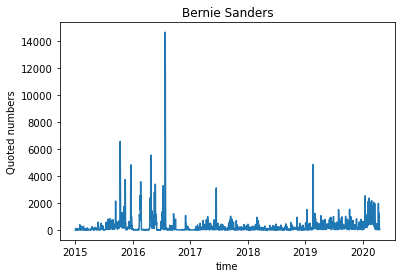

In [188]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].plot()
plt.xlabel('time')
plt.ylabel('Quoted numbers')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [189]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [190]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [191]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['numOccurrences'].sum())
tot_quotes_byelection.rename(columns = {'numOccurrences': 'total_quotes_byelection'}, inplace=True)

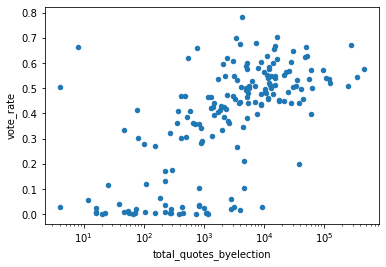

In [192]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)

**Observation:** Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate. The more a candidate was quoted before the election, the higher vote rate he or she got.

## 2. Weigh the quotations by reading statistics
We are aware of the different reading statistics of different publishers or news agencies. We try to weigh the quotations by popularities of the publishers.

**A Bug noticed when parsing url**

**2.1** First, we sample 10k quotes and look at the source publisher of those quotations. This would give us a feel of how much news covered by QuoteBank and what types of publishers are related

In [193]:
# Sample 10k quotes and see where published
sample = candidate_quotes.sample(10000)
total_domains = []
for i in sample.index:
    urls = sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list, not sure why it. can happen; Some are bad
        if isinstance(url, list):
            target = url[0] # when it is a list, the multiply urls point to the same website
        else:
            target = url
        total_domains.append(get_tld(target, as_object=True).domain)

In [194]:
# Count the frequency of publisher/news agency
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("top 30 news agency/publisher: ", domain_count[0:30])
print('number of news agency covered:', len(domain_count))

top 30 news agency/publisher:  [('krmg', 1363), ('msn', 842), ('news965', 789), ('wokv', 613), ('businessinsider', 538), ('einnews', 494), ('thehill', 492), ('washingtonexaminer', 480), ('breitbart', 458), ('cnn', 441), ('yahoo', 390), ('washingtontimes', 378), ('cbsnews', 367), ('newsmax', 344), ('foxnews', 330), ('washingtonpost', 305), ('politico', 296), ('wsbradio', 280), ('huffingtonpost', 262), ('sfgate', 225), ('nbcnews', 207), ('rollcall', 192), ('nytimes', 185), ('newsweek', 174), ('ktvz', 172), ('startribune', 171), ('kvia', 169), ('kdhnews', 169), ('reuters', 155), ('seattletimes', 150)]
number of news agency covered: 3367


Among 10k samples, there are 3367 different website domains, indicating a sufficiently wide coverage of . So the quotations can be an indicator of public exposure.